This notebook pulls the top N Individual stocks and tests cointegration

In [66]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import Kalman
import Cointegration
from statsmodels.tsa.stattools import coint
from statsmodels.api import add_constant, OLS

N = 20
Tickers = [ 'NVDA',  'MSFT', 'AAPL','AMZN','META','AVGO','GOOGL','TSLA', 'GOOG', 'BRK-B',
            'JPM',   'LLY',  'V',   'NFLX','XOM', 'MA',   'ORCL', 'WMT','JNJ','PLTR',
            'COST',  'ABBV', 'HD',  'PG',  'BAC', 'GE',   'UNH',  'CVX','CSCO', 'WFC',
            'IBM',   'AMD',  'KO',  'PM',  'GS',  'ABT',  'CRM',  'RTX','CAT','LIN',
            'MCD',   'MRK',  'DIS', 'UBER','T',   'APP',  'MS',   'PEP','NOW','INTU',
            'MU',    'C',    'VZ',  'TMO', 'AXP', 'QCOM', 'BKNG', 'LRCX','BLK','GEV',
            'TXN',   'AMAT', 'BA',  'SCHW','TJX', 'ISRG', 'NEE',  'ACN','SPGI','AMGN',
            'APH',   'ANET', 'ADBE','INTC','ETN', 'PFE',  'PGR',  'BSX','KLAC', 'LOW',
            'UNP',   'GILD', 'PANW','COF', 'HON', 'SYK',  'DHR',  'BX','CRWD','MDT',
            'ADI',   'WELL', 'ADP', 'COP', 'TMUS','DE',   'CMCSA','MO','HOOD','PLD']

In [67]:
data = yf.download(Tickers[0:N], period='1y', interval='1h')['Close'].dropna()
logPrice = np.log(data)#  - np.log(data.iloc[0])
# Kalman.SpreadFit()


# plt.figure(figsize=(10,6))
# for ticker in Tickers[0:N]:
#     plt.plot(logPrice[ticker], label=ticker)
# # plt.legend()
# plt.title('Log Prices')
# plt.show()

max_plot_N = 3
AssumeSymmetry = False


pairs = [Tickers[i] + '-' + Tickers[j] for i in range(N) for j in range(i+1, N)]
#startDay = logPrice.index[0]
#period = dt.timedelta(days=60)
#delta = dt.timedelta(days=60)
#dates = startDay + period + np.arange(0, (logPrice.index[-1] - logPrice.index[0]) / delta) * delta

# score = pd.DataFrame(index=dates, columns=pairs)
# pvalue = pd.DataFrame(index=dates, columns=pairs)




print("Processing cointegration tests...")
if AssumeSymmetry:
    score = pd.Series(index=pairs)
    pvalue = pd.Series(index=pairs)
    for c, (i, j) in enumerate([(i, j) for i in range(N) for j in range(i+1, N)], start=1):
        pair = Tickers[i] + '-' + Tickers[j]
        score[pair], pvalue[pair], _ = coint(logPrice[Tickers[i]], logPrice[Tickers[j]])
        print(f"{c}/{len(pairs)}: {pair}")
else:
    score = pd.DataFrame(index=Tickers[0:N], columns=Tickers[0:N])
    pvalue = pd.DataFrame(index=Tickers[0:N], columns=Tickers[0:N])
    variance = pd.DataFrame(index=Tickers[0:N], columns=Tickers[0:N])
    for c, (i, j) in enumerate([(i, j) for i in range(N) for j in range(N) if i != j], start=1):
        pair = Tickers[i] + '-' + Tickers[j]
        score.loc[Tickers[i], Tickers[j]], pvalue.loc[Tickers[i], Tickers[j]], _ = coint(logPrice[Tickers[i]], logPrice[Tickers[j]])
        model = OLS(logPrice[Tickers[i]], add_constant(logPrice[Tickers[j]])).fit()
        variance.loc[Tickers[i], Tickers[j]] = np.var(model.resid)
        print(f"{c}/{2*len(pairs)}: {pair}")
print("Completed!")

C:\Users\adamd\AppData\Local\Temp\ipykernel_37292\3836554318.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(Tickers[0:N], period='1y', interval='1h')['Close'].dropna()
[*********************100%***********************]  20 of 20 completed


Processing cointegration tests...
1/380: NVDA-MSFT
2/380: NVDA-AAPL
3/380: NVDA-AMZN
4/380: NVDA-META
5/380: NVDA-AVGO
6/380: NVDA-GOOGL
7/380: NVDA-TSLA
8/380: NVDA-GOOG
9/380: NVDA-BRK-B
10/380: NVDA-JPM
11/380: NVDA-LLY
12/380: NVDA-V
13/380: NVDA-NFLX
14/380: NVDA-XOM
15/380: NVDA-MA
16/380: NVDA-ORCL
17/380: NVDA-WMT
18/380: NVDA-JNJ
19/380: NVDA-PLTR
20/380: MSFT-NVDA
21/380: MSFT-AAPL
22/380: MSFT-AMZN
23/380: MSFT-META
24/380: MSFT-AVGO
25/380: MSFT-GOOGL
26/380: MSFT-TSLA
27/380: MSFT-GOOG
28/380: MSFT-BRK-B
29/380: MSFT-JPM
30/380: MSFT-LLY
31/380: MSFT-V
32/380: MSFT-NFLX
33/380: MSFT-XOM
34/380: MSFT-MA
35/380: MSFT-ORCL
36/380: MSFT-WMT
37/380: MSFT-JNJ
38/380: MSFT-PLTR
39/380: AAPL-NVDA
40/380: AAPL-MSFT
41/380: AAPL-AMZN
42/380: AAPL-META
43/380: AAPL-AVGO
44/380: AAPL-GOOGL
45/380: AAPL-TSLA
46/380: AAPL-GOOG
47/380: AAPL-BRK-B
48/380: AAPL-JPM
49/380: AAPL-LLY
50/380: AAPL-V
51/380: AAPL-NFLX
52/380: AAPL-XOM
53/380: AAPL-MA
54/380: AAPL-ORCL
55/380: AAPL-WMT
56/380: 

In [68]:

# if N<=max_plot_N:
#     num_pairs = N * (N - 1) // 2
#     dim = N-1
#     LogPriceFig, logprice_axes = plt.subplots(dim, dim, figsize=(12, 8))
#     SpreadFig, spread_axes = plt.subplots(dim, dim, figsize=(12, 8))
#     HedgeFig, hedge_axes = plt.subplots(dim, dim, figsize=(12, 8))
#     InterceptFig, intercept_axes = plt.subplots(dim, dim, figsize=(12, 8))
#     scoreFig, score_axes = plt.subplots(dim, dim, figsize=(12, 8))
#     pvalueFig, pvalue_axes = plt.subplots(dim, dim, figsize=(12, 8))
#     print("--------")
#     for i in range(N):
#         for j in range(i+1, N):
#             print(i,j)
#             c = (i * (2 * N - i - 1)) // 2 + (j - i)
#             print(f'{c/num_pairs:.2%} ({c}/{num_pairs})    Processing pair: {Tickers[i]} & {Tickers[j]}')
#             # Spread, theta = Kalman.SpreadFit(logPrice[columns[i]], logPrice[columns[j]])
# 
#             pair = Tickers[i] + '-' + Tickers[j]
#             if N<=max_plot_N:
#                 # score[pair], pvalue[pair], coint_list[pair] = Cointegration.rolling_coint_test(logPrice[columns[i]], logPrice[columns[j]], period=period, delta=delta)
#                 score[pair], pvalue[pair], _ = coint(logPrice[Tickers[i]], logPrice[Tickers[j]])
#             else:
#                 # _, _, coint_list[pair] = Cointegration.rolling_coint_test(logPrice[columns[i]], logPrice[columns[j]], period=period, delta=delta)
#                 score[pair], pvalue[pair], _ = coint(logPrice[Tickers[i]], logPrice[Tickers[j]])
#             print(f"Done With {pair}.  Coint Score: {score[pair]:.4f}, P-Value: {pvalue[pair]:.4f}")
#             if N <= max_plot_N:
#                 score_axes[i,j-1].plot(score[pair])
#                 score_axes[i,j-1].set_title(f'Coint Score: {Tickers[i]} & {Tickers[j]}')
#                 score_axes[i,j-1].axhline(y=-3.9, color='r', linestyle='-', label='Critical Values')
#                 score_axes[i,j-1].axhline(y=-3.3, color='r', linestyle='-')
#                 score_axes[i,j-1].axhline(y=-3.0, color='r', linestyle='-')
# 
#                 pvalue_axes[i,j-1].plot(pvalue[pair])
#                 pvalue_axes[i,j-1].set_title(f'Coint P-Value: {Tickers[i]} & {Tickers[j]}')
#                 pvalue_axes[i,j-1].axhline(y=0.05, color='r', linestyle='--', label='Thresholds')
#                 pvalue_axes[i,j-1].axhline(y=0.01, color='r', linestyle='--')
#                 pvalue_axes[i,j-1].axhline(y=0.10, color='r', linestyle='--')
# 
#                 logprice_axes[i,j-1].scatter(logPrice[columns[i]].values, logPrice[columns[j]].values, c='k', s=1, label='y=x')
#                 logprice_axes[i,j-1].set_title(f'Log Prices: {Tickers[i]} & {Tickers[j]}')
#                 logprice_axes[i,j-1].legend()
# 
#                 spread_axes[i,j-1].plot(Spread)
#                 spread_axes[i,j-1].set_title(f'Spread: {Tickers[i]} - {Tickers[j]}')
# 
#                 hedge_axes[i,j-1].plot(theta['Hedge Ratio'])
#                 # hedge_axes[i,j-1].plot(HR, linestyle='--', color='orange', label='Rolling HR (20)')
#                 # hedge_axes[i,j-1].legend()
#                 hedge_axes[i,j-1].set_title(f'Hedge Ratio: {Tickers[i]} - {Tickers[j]}')
# 
#                 intercept_axes[i,j-1].plot(theta['Intercept'])
#                 # intercept_axes[i,j-1].plot(I, linestyle='--', color='orange', label='Rolling Intercept (20)')
#                 # intercept_axes[i,j-1].legend()
#                 intercept_axes[i,j-1].set_title(f'Intercept: {Tickers[i]} - {Tickers[j]}')
#             print(i,j)
# 
# 
#     if N <= max_plot_N:
#         LogPriceFig.tight_layout()
#         SpreadFig.tight_layout()
#         HedgeFig.tight_layout()
#         InterceptFig.tight_layout()
#         scoreFig.tight_layout()
#         pvalueFig.tight_layout()
# 
# # plt.figure(figsize=(15,14))
# # sns.heatmap(Coint_percentage, xticklabels=Tickers[0:N], yticklabels=Tickers[0:N], annot=True, fmt=".2%", cmap='coolwarm')
# # plt.title('Cointegration Percentage')
# # plt.show()
# 
# # plt.figure(figsize=(15,14))
# # sns.heatmap(logPrice.corr(), xticklabels=Tickers[0:N], yticklabels=Tickers[0:N], annot=True, fmt=".2f", cmap='coolwarm')
# # plt.title('Log Price Correlation')
# # plt.show()

In [69]:
correlation = logPrice.corr()
correlation = pd.DataFrame(correlation, index=Tickers[0:N], columns=Tickers[0:N])
SpreadScore = variance / abs(correlation)

In [70]:
AntiSymmetry_score = np.linalg.norm(score.fillna(0).to_numpy()/2 - score.fillna(0).T.to_numpy()/2) / np.linalg.norm(score.fillna(0).to_numpy())
print(f"Anti-Symmetry Score: {AntiSymmetry_score:.4%}")

Anti-Symmetry Score: 26.3571%


C:\Users\adamd\AppData\Local\Temp\ipykernel_37292\1254294616.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  AntiSymmetry_score = np.linalg.norm(score.fillna(0).to_numpy()/2 - score.fillna(0).T.to_numpy()/2) / np.linalg.norm(score.fillna(0).to_numpy())
C:\Users\adamd\AppData\Local\Temp\ipykernel_37292\1254294616.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  AntiSymmetry_score = np.linalg.norm(score.fillna(0).to_numpy()/2 - score.fillna(0).T.to_numpy()/2) / np.linalg.norm(score.fillna(0).to_numpy())


In [71]:
# coint_list = coint_list.sort_values(ascending=False)
# coint_list
pvalue = pvalue.stack()
pvalue.index = pvalue.index.map(lambda x: x[0] + '-' + x[1])
pvalue = pvalue.sort_values()
pvalue




XOM-V        0.006785
NVDA-ORCL    0.010409
MA-PLTR      0.010812
JPM-META     0.012434
ORCL-NVDA      0.0148
               ...   
JNJ-AAPL     0.983126
JNJ-AMZN     0.985132
JNJ-LLY      0.985939
JNJ-V        0.987977
JNJ-TSLA     0.988165
Length: 380, dtype: object

In [72]:
score = score.stack()
score.index = score.index.map(lambda x: x[0] + '-' + x[1])
score = score.sort_values()
score

XOM-V       -4.017224
NVDA-ORCL    -3.88479
MA-PLTR     -3.872744
JPM-META    -3.828011
ORCL-NVDA   -3.771255
               ...   
JNJ-AAPL    -0.105482
JNJ-AMZN    -0.031876
JNJ-LLY      0.001675
JNJ-V        0.100283
JNJ-TSLA     0.110655
Length: 380, dtype: object

In [73]:
variance = variance.stack()
variance.index = variance.index.map(lambda x: x[0] + '-' + x[1])
variance = variance.sort_values()
variance

GOOG-GOOGL    0.000004
GOOGL-GOOG    0.000004
MA-JPM        0.000743
MA-NFLX       0.000749
MA-PLTR       0.000768
                ...   
PLTR-AMZN     0.135435
PLTR-XOM      0.142387
PLTR-BRK-B    0.145086
PLTR-TSLA     0.149207
PLTR-AAPL     0.168206
Length: 380, dtype: object

In [74]:
SpreadScore = SpreadScore.stack()
SpreadScore.index = SpreadScore.index.map(lambda x: x[0] + '-' + x[1])
SpreadScore = SpreadScore.sort_values()
SpreadScore

GOOG-GOOGL    0.000004
GOOGL-GOOG    0.000004
MA-JPM        0.000886
MA-NFLX       0.000896
MA-PLTR       0.000922
                ...   
BRK-B-LLY     0.898603
TSLA-JNJ      1.118267
PLTR-AAPL     1.155934
AVGO-BRK-B    2.012078
LLY-BRK-B     2.344869
Length: 380, dtype: object

In [75]:
corr_list = logPrice.corr()
corr_list = [(Tickers[i], Tickers[j], corr_list.iloc[i,j]) for i,j in zip(*np.triu_indices(N, k=1))]
corr_list = pd.DataFrame(corr_list, columns=['Ticker1', 'Ticker2', 'Correlation'])
corr_list = corr_list.sort_values(by='Correlation', ascending=False).reset_index(drop=True)
corr_list



,Ticker1,Ticker2,Correlation
0,META,AVGO,0.999885
1,V,MA,0.953357
2,NFLX,XOM,0.940301
3,LLY,NFLX,0.915460
4,TSLA,JPM,0.904499
...,...,...,...
185,GOOG,V,-0.460972
186,GOOG,MA,-0.479454
187,GOOG,LLY,-0.484718
188,JNJ,PLTR,-0.495996


                            OLS Regression Results                            
Dep. Variable:                     MA   R-squared:                       0.703
Model:                            OLS   Adj. R-squared:                  0.703
Method:                 Least Squares   F-statistic:                     4107.
Date:                Thu, 09 Oct 2025   Prob (F-statistic):               0.00
Time:                        17:45:35   Log-Likelihood:                 3795.4
No. Observations:                1738   AIC:                            -7587.
Df Residuals:                    1736   BIC:                            -7576.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.0364      0.035    113.861      0.0

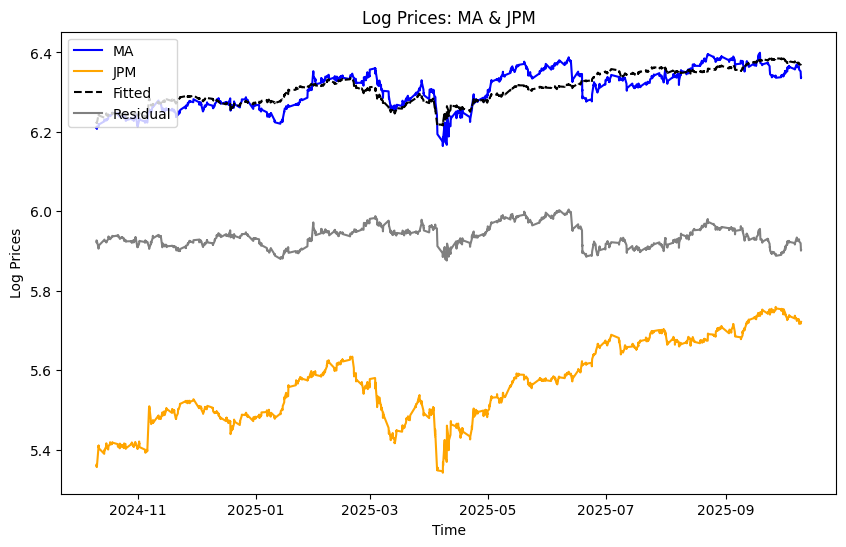

In [77]:
from statsmodels.tsa.stattools import coint
from statsmodels.api import OLS, add_constant
Pair = 'MA-JPM'
tick1, tick2 = Pair.split('-')
model = OLS(logPrice[tick1], add_constant(logPrice[tick2])).fit()
print(model.summary())
print(f"Residual Variance: {np.var(model.resid)}")
s, p, c = coint(logPrice[tick1], logPrice[tick2])
print(f'Cointegration test for {tick1} & {tick2}: p-value={p}, t-stat={s}, crit-values={c}')
s, p, c = coint(logPrice[tick2], logPrice[tick1])
print(f'Cointegration test for {tick1} & {tick2}: p-value={p}, t-stat={s}, crit-values={c}')

plt.subplots(figsize=(10,6))

# Primary y-axis for prices
plt.plot(logPrice[tick1], label=tick1, color='blue')
plt.plot(logPrice[tick2], label=tick2, color='orange')
plt.plot(model.fittedvalues, label='Fitted', linestyle='--', color='k')
plt.plot(model.resid + np.mean(logPrice[tick1] + logPrice[tick2])/2, label='Residual', linestyle='-', color='gray')
plt.xlabel('Time')
plt.ylabel('Log Prices', color='black')
plt.legend(loc='upper left')

plt.title(f'Log Prices: {tick1} & {tick2}')
plt.show()